In [3]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import Network
import networkx as nx
from external_world import ExternalWorld, MNISTExternalWorld


def jaynes():
    #TODO
    pass

def plot_network_structure(net: Network):
    G = nx.DiGraph()
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    # Add nodes explicitly with subset attribute
    for layer_idx, layer_label in enumerate(layer_labels):
        layer_size = net.weights[0].shape[0] if layer_idx == 0 else net.weights[layer_idx - 1].shape[1]
        for neuron_idx in range(layer_size):
            G.add_node((layer_label, neuron_idx), subset=layer_idx)

    # Add edges
    for idx, W in enumerate(net.weights):
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                G.add_edge((layer_labels[idx], i), (layer_labels[idx + 1], j))

    pos = nx.multipartite_layout(G)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_size=50, arrowsize=5)
    plt.title("Network Structure")
    plt.show()

def plot_network_weights(net: Network, epoch):
    G = nx.DiGraph()
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    for i, layer_size in enumerate([net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]):
        for n in range(layer_size):
            G.add_node((layer_labels[i], n), subset=i)

    for idx, W in enumerate(net.weights):
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                weight = W[i, j].item()
                G.add_edge((layer_labels[idx], i), (layer_labels[idx+1], j), weight=weight)

    pos = nx.multipartite_layout(G, subset_key='subset')
    edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

    plt.figure(figsize=(5, 2))
    
    # Normalize edge colors and explicitly create a ScalarMappable
    norm = plt.Normalize(vmin=-np.max(np.abs(edge_weights)), vmax=np.max(np.abs(edge_weights)))
    cmap = plt.cm.RdYlGn

    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_weights, edge_cmap=cmap, edge_vmin=norm.vmin, edge_vmax=norm.vmax, arrowsize=10)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='gray')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(edge_weights)
    plt.colorbar(sm, label='Weight magnitude', ax = plt.gca())

    plt.title(f"Network Structure at Epoch {epoch}")
    plt.axis('off')
    plt.show()


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import pickle
from util.activation import *
from util.energy import *


def hopfield(layers, weights, biases):
    """Compute the energy function E for the current layers."""
    # squared_norm: for each layer, sum of squares of each row, then sum over layers.
    squared_norm = sum([(layer * layer).sum(dim=1) for layer in layers]) / 2.0
    # linear_terms: for each layer, compute dot(layer, bias).
    linear_terms = -sum([torch.matmul(layer, b) for layer, b in zip(layers, biases)])
    # quadratic_terms: for each adjacent pair of layers.
    quadratic_terms = -sum([
        ((torch.matmul(pre, W)) * post).sum(dim=1)
        for pre, W, post in zip(layers[:-1], weights, layers[1:])
    ])
    return squared_norm + linear_terms + quadratic_terms


class Network:
    def __init__(self, name, external_world, hyperparameters={}):
        self.path = name + ".save"
        self.external_world = external_world
        self.hyperparameters = hyperparameters

        input_size = external_world.x.shape[1]
        output_size = hyperparameters.get("output_size", len(torch.unique(external_world.y)))
        layer_sizes = [input_size] + hyperparameters["hidden_sizes"] + [output_size]

        self.biases, self.weights, self.training_curves = self._initialize_params(layer_sizes)
        self.batch_size = hyperparameters["batch_size"]
        self.dataset_size = external_world.size_dataset
        self.persistent_particles = [torch.zeros((self.dataset_size, size)) for size in layer_sizes[1:]]
        self.index = 0
        self.activation_deriv = get_activation_deriv(
            hyperparameters.get("activation", "pi")
        )


    def _initialize_params(self, layer_sizes):
        biases = [torch.zeros(size) for size in layer_sizes]
        weights = [torch.tensor(np.random.uniform(-np.sqrt(6 / (n_in + n_out)), 
                        np.sqrt(6 / (n_in + n_out)), (n_in, n_out)), dtype=torch.float32)
                   for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        return biases, weights, {"training error": [], "validation error": []}

    def update_mini_batch_index(self, index):
        start, end = index * self.batch_size, (index + 1) * self.batch_size
        self.x_data, self.y_data = self.external_world.x[start:end], self.external_world.y[start:end]
        output_size = self.hyperparameters["output_size"]
        self.y_data_one_hot = F.one_hot(self.y_data, num_classes=output_size).float()
        self.layers = [self.x_data] + [p[start:end] for p in self.persistent_particles]

    def energy(self, layers):
        """Compute the energy function E for the current layers."""
        energy_fn = self.hyperparameters["energy_fn"] if "energy_fn" in self.hyperparameters else "hopfield"

        if energy_fn == 'none':
            pass
        elif energy_fn == 'hopfield':
            return hopfield(layers, self.weights, self.biases)
        else:
            raise ValueError('Unknown energy function type: {}'.format(energy_fn))

    def cost(self, layers):
        # Squared error cost between the last layer and the one-hot labels.
        return ((layers[-1] - self.y_data_one_hot) ** 2).sum(dim=1)
    
    def activation(self, neurons):
        """Compute the activation of the given neurons' values."""
        activation = self.hyperparameters["activation"] if "activation" in self.hyperparameters else "pi"
        return get_activation(activation, neurons)
    
    def measure(self):
        """Measure the average energy, cost, and error over the current mini-batch."""
        E = self.energy(self.layers).mean().item()
        C = self.cost(self.layers).mean().item()
        y_prediction = self.layers[-1].argmax(dim=1)
        error = (y_prediction != self.y_data).float().mean().item()
        return E, C, error
    

    def _update_layer_gradient(self, u_k, u_prev, u_next, W_prev, W_next, b_k, eta):
        """
        Perform one gradient descent step on a hidden layer using the energy gradient.
        """
        activation = self.activation
        activation_deriv = self.activation_deriv

        drive = torch.matmul(u_prev, W_prev) + torch.matmul(activation(u_next), W_next.T) + b_k
        grad = activation_deriv(u_k) * drive - u_k
        return u_k - eta * grad
    
    def negative_phase(self, n_iterations, eta=0.1):
        """
        Perform negative phase: relax using energy gradient descent with unclamped output.
        """
        layers = [self.x_data] + [layer.clone() for layer in self.layers[1:]]

        for _ in range(n_iterations):
            new_layers = [layers[0]]  # input clamped

            for k in range(1, len(layers) - 1):
                u_k = layers[k]
                u_prev = layers[k - 1]
                u_next = layers[k + 1]
                W_prev = self.weights[k - 1]
                W_next = self.weights[k]
                b_k = self.biases[k]

                u_k_updated = self._update_layer_gradient(u_k, u_prev, u_next, W_prev, W_next, b_k, eta)
                new_layers.append(u_k_updated)

            # Output layer forward pass
            out_input = torch.matmul(new_layers[-1], self.weights[-1]) + self.biases[-1]
            new_layers.append(self.activation(out_input))

            layers = new_layers

        # Update persistent particles
        start = self.index * self.batch_size
        end = (self.index + 1) * self.batch_size
        for i in range(len(self.persistent_particles)):
            self.persistent_particles[i][start:end] = layers[i + 1].detach()

    self.layers = [self.x_data] + [p[start:end] for p in self.persistent_particles]


    
    
    def positive_phase(self, n_iterations, *alphas, eta=0.1):
        """
        Positive phase: relax with clamped output and update weights via free/clamped difference.
        """
        batch_size = self.x_data.shape[0]
        free_layers = self.layers
        clamped_layers = [self.x_data] + [layer.clone().detach() for layer in self.layers[1:-1]]
        clamped_layers.append(self.y_data_one_hot)

        for _ in range(n_iterations):
            new_layers = [clamped_layers[0]]
            for k in range(1, len(clamped_layers) - 1):
                u_k = clamped_layers[k]
                u_prev = clamped_layers[k - 1]
                u_next = clamped_layers[k + 1]
                W_prev = self.weights[k - 1]
                W_next = self.weights[k]
                b_k = self.biases[k]

                u_k_updated = self._update_layer_gradient(u_k, u_prev, u_next, W_prev, W_next, b_k, eta)
                new_layers.append(u_k_updated)
            new_layers.append(self.y_data_one_hot)  # keep output clamped
            clamped_layers = new_layers

        # Weight and bias update
        Delta_layers = [clamped - free for clamped, free in zip(clamped_layers[1:], free_layers[1:])]
        for i, delta in enumerate(Delta_layers, start=1):
            self.biases[i] += alphas[i - 1] * delta.mean(dim=0)
        for i, delta in enumerate(Delta_layers):
            self.weights[i] += alphas[i] * (free_layers[i].T @ delta) / batch_size

    def save_params(self):
        biases_values = [b.detach().numpy() for b in self.biases]
        weights_values = [W.detach().numpy() for W in self.weights]
        to_dump = (biases_values, weights_values, self.hyperparameters, self.training_curves)
        with open(self.path, "wb") as f:
            pickle.dump(to_dump, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def __load_params(self, hyperparameters):
        hyper = hyperparameters.copy()
        if os.path.isfile(self.path):
            with open(self.path, "rb") as f:
                biases_values, weights_values, saved_hyper, training_curves = pickle.load(f)
            saved_hyper.update(hyper)
            hyper = saved_hyper
        else:
            layer_sizes = [28 * 28] + hyper["hidden_sizes"] + [10]
            biases_values = [np.zeros((size,), dtype=np.float32) for size in layer_sizes]
            weights_values = []
            # Glorot/Bengio weight initialization for each layer.
            for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
                limit = np.sqrt(6.0 / (n_in + n_out))
                W = np.random.uniform(low=-limit, high=limit, size=(n_in, n_out)).astype(np.float32)
                weights_values.append(W)
            training_curves = {"training error": [], "validation error": []}
        
        # Convert loaded parameters to torch tensors.
        biases = [torch.tensor(b, dtype=torch.float32) for b in biases_values]
        weights = [torch.tensor(W, dtype=torch.float32) for W in weights_values]
        return biases, weights, hyper, training_curves
    def clamp(self, x_batch, y_batch=None):
        """Clamp x (and optionally y) and rebuild layers for a forward pass."""
        self.x_data = x_batch
        self.y_data = y_batch if y_batch is not None else torch.zeros(x_batch.size(0), dtype=torch.long)
        output_size = self.hyperparameters.get("output_size", 10)
        self.y_data_one_hot = F.one_hot(self.y_data, num_classes=output_size).float()
        
        # Create fresh internal state for evaluation (no persistent particles)
        self.layers = [self.x_data]
        for k in range(len(self.weights)):
            size = self.weights[k].shape[1]  # output size of this layer
            self.layers.append(torch.zeros((x_batch.size(0), size)))





In [3]:
def evaluate_test_batch(net, n_samples=100, n_iter=20):
    """Evaluate test performance using a forward relaxation pass."""
    x_batch = net.external_world.x_test[:n_samples]
    y_batch = net.external_world.y_test[:n_samples]

    net.x_data = x_batch
    net.y_data = y_batch

    net.clamp(x_batch, None)
    net.negative_phase(n_iterations=n_iter)

    preds = net.layers[-1].argmax(dim=1)

    print(preds.shape)
    error = (preds != y_batch).float().mean().item()

    return error * 100  # percent


def train_net(net, plot_graph=False, test_every=1):
    history = {
        "Energy": [], "Cost": [], "Error": [],
        "TestError": []
    }

    epochs = net.hyperparameters["n_epochs"]
    batch_size = net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg = net.hyperparameters["n_it_neg"]
    n_it_pos = net.hyperparameters["n_it_pos"]
    alphas = net.hyperparameters["alphas"]

    snapshot_epochs = np.linspace(0, epochs - 1, 5, dtype=int)

    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
        for epoch in range(epochs):
            for i in range(n_batches):
                net.update_mini_batch_index(i)
                net.negative_phase(n_it_neg)
                net.positive_phase(n_it_pos, *alphas)

            # Train stats
            E, C, error = net.measure()
            history["Energy"].append(E)
            history["Cost"].append(C)
            history["Error"].append(error * 100)

            # Test stats
            if epoch % test_every == 0 or epoch == epochs - 1:
                error_test = evaluate_test_batch(net)
                history["TestError"].append(error_test)
            else:
                history["TestError"].append(None)

            epoch_bar.set_description(
                f"Epoch {epoch+1}/{epochs} | E={E:.2f} C={C:.5f} TrainErr={error*100:.2f}%"
                + (f" TestErr={error_test:.2f}%" if epoch % test_every == 0 else "")
            )
            epoch_bar.update(1)

            if plot_graph and epoch in snapshot_epochs:
                plot_network_weights(net, epoch)

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(history["Error"], label="Train Error", color="red", linestyle="-")
    axes[0].plot([e for e in history["TestError"] if e is not None], label="Test Error", color="red", linestyle="--")
    axes[0].set_title("Error over Epochs")
    axes[0].legend()

    axes[1].plot(history["Energy"], label="Energy", color="blue")
    axes[1].set_title("Energy over Epochs")
    axes[1].legend()

    plt.tight_layout()
    plt.show();

    return history


Epoch 1/10 | E=-9.48 C=0.19059 TrainErr=9.00% TestErr=17.00%:  10%|█         | 1/10 [00:00<00:03,  2.35epoch/s]

torch.Size([100])


Epoch 2/10 | E=-22.02 C=0.18703 TrainErr=11.00% TestErr=16.00%:  20%|██        | 2/10 [00:00<00:03,  2.45epoch/s]

torch.Size([100])


Epoch 3/10 | E=-33.85 C=0.18267 TrainErr=10.00% TestErr=19.00%:  30%|███       | 3/10 [00:01<00:03,  2.32epoch/s]

torch.Size([100])


Epoch 4/10 | E=-42.40 C=0.18697 TrainErr=10.00% TestErr=15.00%:  40%|████      | 4/10 [00:01<00:02,  2.10epoch/s]

torch.Size([100])


Epoch 5/10 | E=-44.64 C=0.20095 TrainErr=9.00% TestErr=20.00%:  50%|█████     | 5/10 [00:02<00:02,  2.18epoch/s] 

torch.Size([100])


Epoch 6/10 | E=-47.11 C=0.18353 TrainErr=9.00% TestErr=15.00%:  60%|██████    | 6/10 [00:02<00:01,  2.06epoch/s]

torch.Size([100])


Epoch 7/10 | E=-64.72 C=0.19862 TrainErr=11.00% TestErr=17.00%:  70%|███████   | 7/10 [00:03<00:01,  2.14epoch/s]

torch.Size([100])


Epoch 8/10 | E=-61.49 C=0.15076 TrainErr=9.00% TestErr=13.00%:  80%|████████  | 8/10 [00:03<00:00,  2.20epoch/s] 

torch.Size([100])


Epoch 9/10 | E=-56.84 C=0.17491 TrainErr=9.00% TestErr=15.00%:  90%|█████████ | 9/10 [00:04<00:00,  2.18epoch/s]

torch.Size([100])


Epoch 10/10 | E=-77.75 C=0.13620 TrainErr=9.00% TestErr=13.00%: 100%|██████████| 10/10 [00:04<00:00,  2.21epoch/s]

torch.Size([100])


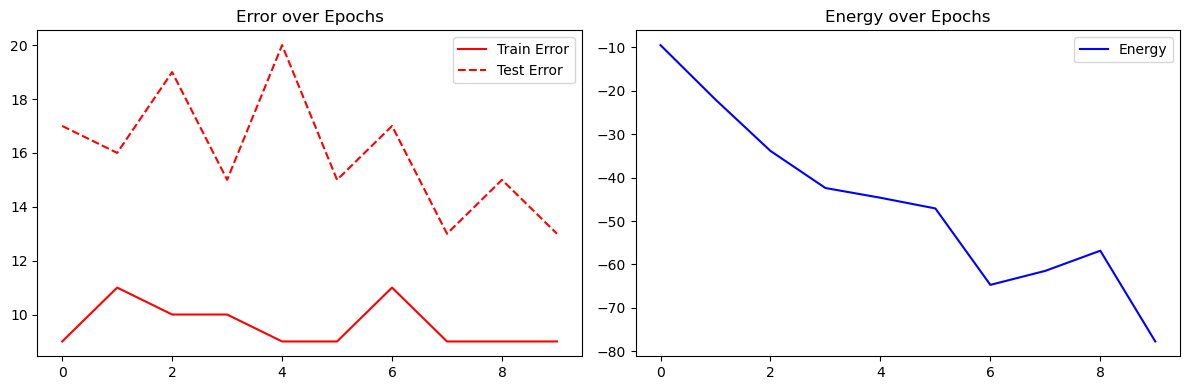

In [4]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx


class ExternalWorld:
    def __init__(self, n_per_class=5000, n_test_per_class=200, noise_std=0.02, seed=42):
        
        path = os.path.join(os.getcwd(), "mnist.pkl.gz")
        if not os.path.isfile(path):
            urlretrieve("http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz", path)
        with gzip.open(path, "rb") as f:
            train, valid, test = pickle.load(f, encoding="latin1")

        x_all = np.vstack((train[0], valid[0], test[0]))
        y_all = np.hstack((train[1], valid[1], test[1]))

        np.random.seed(seed)

        x_train_list, y_train_list = [], []
        x_test_list, y_test_list = [], []

        for digit in range(10):
            idxs = np.where(y_all == digit)[0]
            chosen = np.random.choice(idxs, n_per_class + n_test_per_class, replace=False)
            x_train_list.append(x_all[chosen[:n_per_class]])
            y_train_list.append(np.full(n_per_class, digit))
            x_test_list.append(x_all[chosen[n_per_class:]])
            y_test_list.append(np.full(n_test_per_class, digit))

        x_train = np.vstack(x_train_list).astype(np.float32)
        y_train = np.hstack(y_train_list).astype(np.int64)
        x_test = np.vstack(x_test_list).astype(np.float32)
        y_test = np.hstack(y_test_list).astype(np.int64)

        # Shuffle training data
        train_perm = np.random.permutation(len(x_train))
        test_perm = np.random.permutation(len(x_test))

        self.x = torch.tensor(x_train[train_perm])
        self.y = torch.tensor(y_train[train_perm])
        self.x_test = torch.tensor(x_test[test_perm])
        self.y_test = torch.tensor(y_test[test_perm])
        self.size_dataset = len(self.x)








mnist_net = Network("mnist", ExternalWorld(), {
    "hidden_sizes": [500],
    "n_epochs": 10,
    "batch_size": 100,
    "n_it_neg": 1,
    "n_it_pos": 1,
    "alphas": [np.float32(0.1), np.float32(0.5), np.float32(0.4)],
    "output_size": 10,
})
# Initialize and train
train_net(mnist_net);








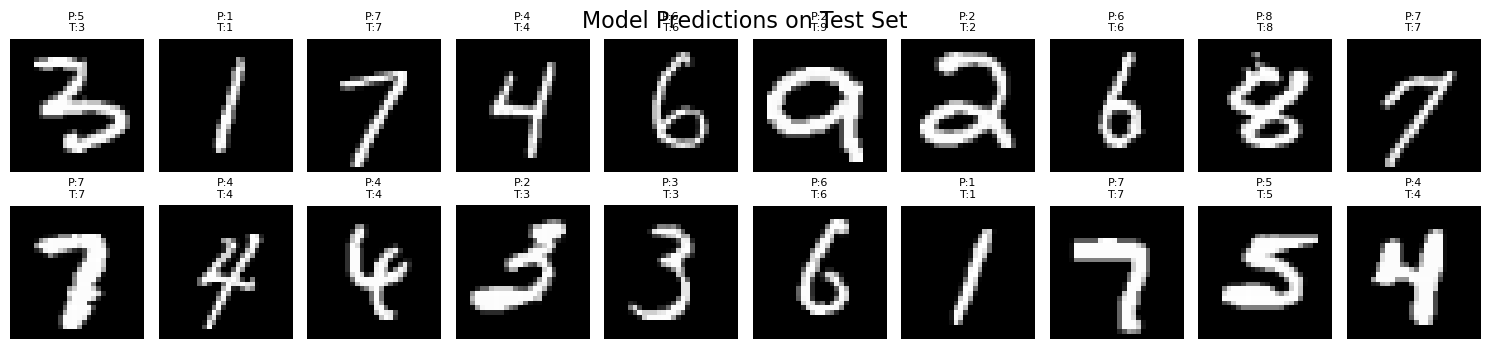

In [5]:
import matplotlib.pyplot as plt

class ShapeOverride:
    def __init__(self, batch_size):
        self.index = 0
        self.batch_size = batch_size

def show_predictions(net, test_x, test_y, n_samples=20, n_iter=20):
    x_batch = test_x[:n_samples]
    y_batch = test_y[:n_samples]

    net.x_data = x_batch
    net.y_data = y_batch

    net.clamp(x_batch, None)

    shape_override = ShapeOverride(n_samples)
    net.negative_phase(n_iterations=n_iter, shape_self=shape_override)

    output = net.layers[-1]
    if output.ndim != 2 or output.shape[1] != 10:
        print(f"[WARNING] Unexpected output shape: {output.shape}")

    preds = output.argmax(dim=1).cpu().numpy()
    true_labels = y_batch.cpu().numpy()
    images = x_batch.view(-1, 28, 28).cpu().numpy()

    # Set grid size: 10 per row
    cols = 10
    rows = (n_samples + cols - 1) // cols  # Ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 1.8 * rows))
    axes = axes.flatten()

    for i in range(n_samples):
        axes[i].imshow(images[i], cmap="gray")
        axes[i].set_title(f"P:{preds[i]}\nT:{true_labels[i]}", fontsize=8)
        axes[i].axis("off")

    # Hide any extra unused subplots
    for i in range(n_samples, len(axes)):
        axes[i].axis("off")

    plt.suptitle("Model Predictions on Test Set", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()




show_predictions(mnist_net, mnist_net.external_world.x_test, mnist_net.external_world.y_test)


In [6]:
def mcmc_trajectory(net, x, n_steps=200, layer_noise_std=0.02):
    """
    Clamp input x, run MCMC on hidden/output layers, and record energy over time.
    
    Args:
        net: trained Network
        x: input image, shape [1, input_dim]
        n_steps: number of MCMC steps
        layer_noise_std: proposal noise std for hidden/output layers

    Returns:
        energies: list of scalar energies
        states: list of full layer states (e.g. for PCA)
        preds: list of predicted class at each step
    """
    with torch.no_grad():
        x = x.view(1, -1)
        weights = [W.clone() for W in net.weights]
        biases = [b.clone() for b in net.biases]

        # Initialize layers (x is clamped)
        layers = [x] + [
            torch.randn(1, b.shape[0]) * 0.01 for b in biases[1:]
        ]
        energies = []
        preds = []
        states = []

        for step in range(n_steps):
            proposal = [x]
            for l in layers[1:]:
                proposal.append(l + torch.randn_like(l) * layer_noise_std)
            
            E_current = hopfield(layers, weights, biases)
            E_proposal = hopfield(proposal, weights, biases)

            # Accept/reject
            accept_prob = torch.exp(E_current - E_proposal)
            if torch.rand(1) < accept_prob:
                layers = proposal

            # Log
            energies.append(hopfield(layers, weights, biases).item())
            preds.append(layers[-1].argmax(dim=1).item())
            states.append(torch.cat(layers[1:], dim=1).squeeze().cpu().numpy())

        return energies, preds, states


In [7]:
from collections import defaultdict

def collect_mcmc_trajectories(net, samples_per_class=5, n_steps=200):
    xs = net.external_world.x
    ys = net.external_world.y
    all_states = []
    all_labels = []
    all_preds = []

    class_counts = defaultdict(int)
    max_per_class = samples_per_class

    for i in range(len(xs)):
        label = ys[i].item()
        if class_counts[label] >= max_per_class:
            continue

        x_sample = xs[i].unsqueeze(0)
        energies, preds, states = mcmc_trajectory(net, x_sample, n_steps=n_steps)
        
        all_states.extend(states)
        all_labels.extend([label] * len(states))
        all_preds.extend(preds)
        class_counts[label] += 1

        if sum(class_counts.values()) >= samples_per_class * 22:
            break

    return np.array(all_states), np.array(all_labels), np.array(all_preds)


In [8]:
from sklearn.manifold import TSNE

def plot_tsne(states, labels, title="MCMC t-SNE"):
    tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
    reduced = tsne.fit_transform(states)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab20', s=5, alpha=0.8)
    plt.colorbar(scatter, label="Original Class")
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()


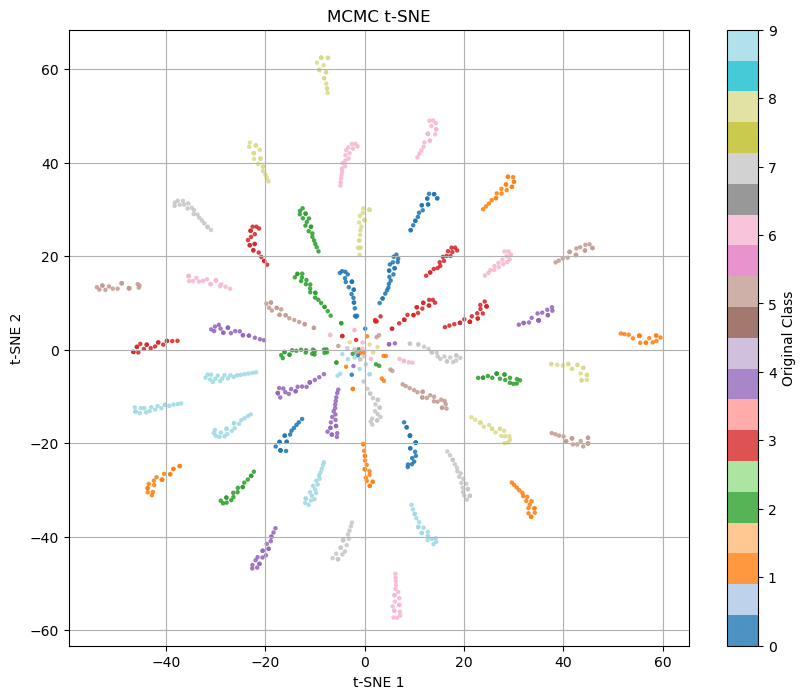

In [9]:
states, labels, preds = collect_mcmc_trajectories(mnist_net, samples_per_class=5, n_steps=20)
plot_tsne(states, labels)


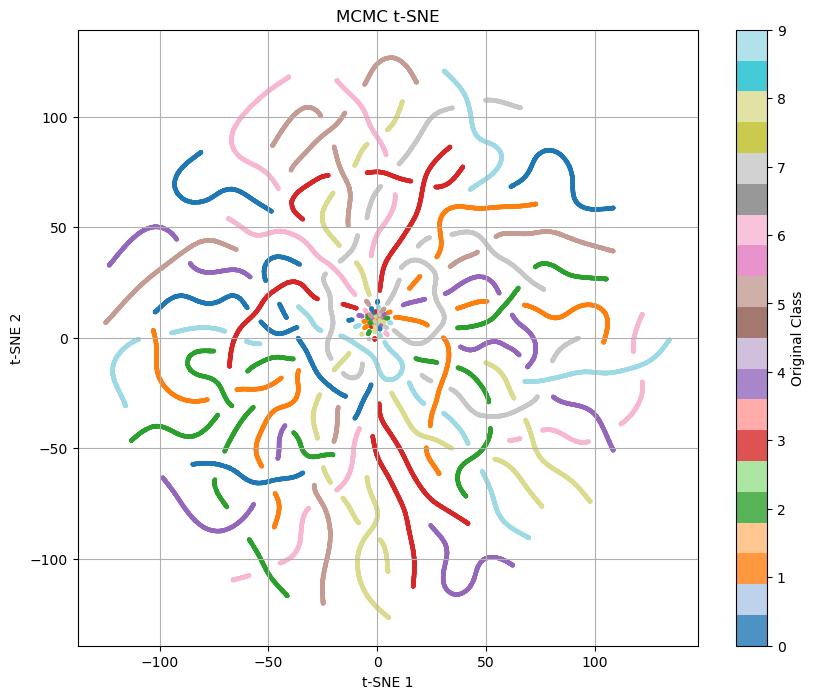

In [10]:
states, labels, preds = collect_mcmc_trajectories(mnist_net, samples_per_class=5, n_steps=500)
plot_tsne(states, labels)


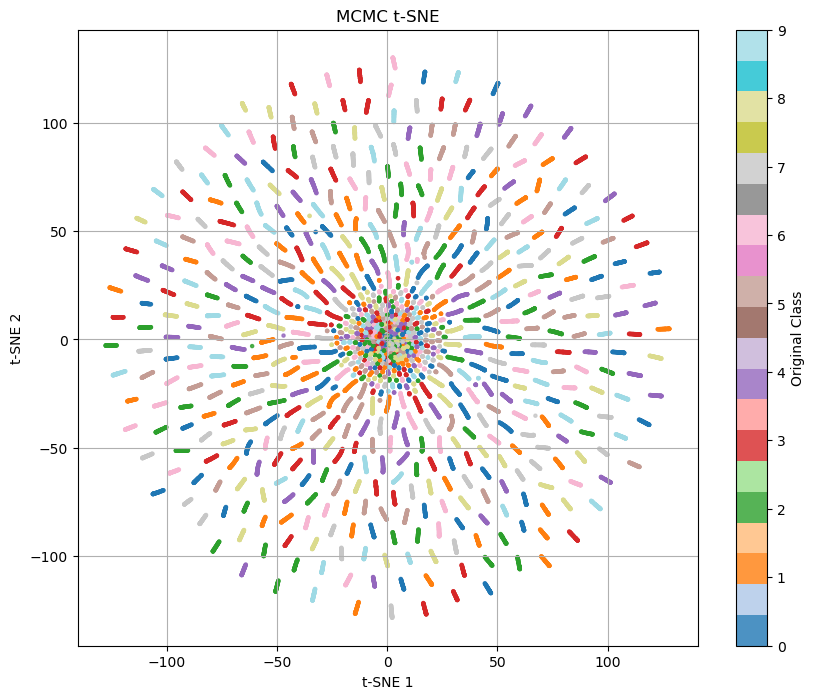

In [11]:
states, labels, preds = collect_mcmc_trajectories(mnist_net, samples_per_class=50, n_steps=50)
plot_tsne(states, labels)
